#**Exploratory study of disks evolution dataset** *Version of 25/10/2022*


*   **Objectif :** getting familiar with the given datasets starting with 'disk_evolution' data
*   __The steps of the conducted study are as follow :__ 
  - Getting raw data into dataframe and getting general infos (mean, std, nb missing values ... etc)
  - Parsing the time index and filling missing values if there are any
  - Randomly selecting a subset of disks for full execution on Colab
  - **Resampling** data as daily, weekly and monthly
  - Plotting original time series
  - Executing an **unsupervised clustering** on data
  - Visualizing first differecing of data
  - Doing a modified Mann-Kendall test to extract apparent **Trend**
  - Implementing analysis indicators : 
      - **Additive** decomposition function
      - **Changepoints** detection with : **CumSum** and **Bocdp** from Kats
      - **FFT** plot and calculations for **seasonality** test
      - **Outliers** detection and removal

* **Outputs of this study**
  - Cleaned and parsed dataset
  - A .csv resuming results of tests for each disk
  - Useful plots will be saved for future use









---



### **Importing packages for different uses** 

In [1]:
!pip install dtw-python
!pip install pymannkendall
!pip install --upgrade pip
!pip install kats==0.1 ax-platform==0.2.3 statsmodels==0.12.2
!git clone https://github.com/tejaslodaya/timeseries-clustering-vae.git
!pip install tslearn
!pip uninstall scikit-learn --yes 
!pip install scikit-learn==0.24.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 247, in wrapper
    return func(self, options, args)
  File "/usr/lo

In [2]:
!pip install kats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Packages to manipulate data
import pandas as pd
import numpy as np

#Packages for data visualization
import matplotlib.pyplot as plt 
from matplotlib import rcParams 
import seaborn as sns

#Choosing styling params
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

#date manipulation packages
import datetime as dt


#tslearn packages for unsupervised clustering task
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram
from tqdm.autonotebook import tqdm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


#package to test seasonality
from scipy.stats import kruskal


#packages to extract outliers, changeponts, seasonlity_presence and decomposition
from zmq import NULL
from kats.consts import TimeSeriesData
from kats.utils.decomposition import TimeSeriesDecomposition
from kats.detectors.seasonality import FFTDetector
from kats.detectors.cusum_detection import CUSUMDetector
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters
from kats.detectors.outlier import OutlierDetector
from kats.detectors.seasonality import ACFDetector
from kats.consts import TimeSeriesChangePoint
from kats.consts import TimeSeriesChangePoint


#packages to detect trend
import pymannkendall as pmk
from statsmodels.tsa.seasonal import seasonal_decompose


#Python packages to organize prints and figures displays
from IPython.display import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
#Mounting data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Different paths
disk_evolutions_path = './drive/Shareddrives/[PFE][ESI-ALGER][LINDA BELKESSA]/Codes/EDA_Infologic_dataset/clean_disk_evolution_series.csv'
eda_dumps_disks = './drive/Shareddrives/[PFE][ESI-ALGER][LINDA BELKESSA]/Codes/EDA_Infologic_dataset/eda_dumps/disks evolution/'

###**Raw data exploration**

In [6]:
#Loading the cleaned dataset
disks_evol = pd.read_csv(disk_evolutions_path)

disks_evol.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2912,2913,2914,2915,2916,2917,2918,2919,2920,2921
0,2021-01-04 12:00:00,0.786654,0.641158,0.574148,0.760861,0.822923,0.224135,0.572822,0.636559,0.594383,...,0.99871,0.862324,0.595604,0.866838,0.646921,0.713123,0.50858,0.419542,0.674262,0.999969
1,2021-01-04 14:00:00,0.786680,0.641158,0.574141,0.760850,0.822923,0.224163,0.572781,0.636559,0.593857,...,0.99871,0.862324,0.595600,0.866491,0.646819,0.713123,0.50858,0.419536,0.674262,0.999969
2,2021-01-04 16:00:00,0.786676,0.641158,0.574117,0.760795,0.822923,0.224148,0.572718,0.636559,0.592637,...,0.99871,0.862324,0.595595,0.865829,0.646708,0.713123,0.50858,0.419526,0.674262,0.999969
3,2021-01-04 18:00:00,0.786675,0.641158,0.574068,0.760810,0.822923,0.224156,0.572656,0.636559,0.593411,...,0.99871,0.862324,0.595590,0.865141,0.646915,0.713123,0.50858,0.419516,0.674262,0.999969
4,2021-01-04 20:00:00,0.786675,0.641158,0.574067,0.760873,0.822923,0.224152,0.572605,0.636559,0.593502,...,0.99871,0.862324,0.595585,0.864614,0.647441,0.713122,0.50858,0.419506,0.674262,0.999969


In [7]:
#Randomly selecting 100 columns (series) for in-depth EDA

#sampling randomly 100 disks

df_hourly = disks_evol.sample(n=100, axis='columns',replace='False')

#parsing and formatting index for all timestamps
index = disks_evol[disks_evol.columns[0]] 
parse_index =  [dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in index]

df_hourly.index = parse_index
df_hourly.drop(columns=df_hourly.columns[0], inplace=True)

In [8]:
df_hourly.head(10)

,2226,2429,161,773,406,675,2562,2643,2360,994,...,2203,1915,99,2216,955,1584,2573,1457,2812,57
2021-01-04 12:00:00,0.887883,0.768665,0.94629,0.645795,0.774486,0.941607,0.903613,0.932885,0.441666,0.768750,...,0.184923,0.559756,0.935859,0.497633,0.931578,0.999996,0.772406,0.992368,0.505609,0.94614
2021-01-04 14:00:00,0.887881,0.768665,0.94629,0.645652,0.774486,0.941464,0.903596,0.932803,0.441515,0.768750,...,0.181947,0.559748,0.935771,0.497618,0.931534,0.999996,0.772406,0.992369,0.505609,0.94614
2021-01-04 16:00:00,0.887880,0.768664,0.94629,0.645346,0.774486,0.941281,0.903565,0.932672,0.441400,0.768751,...,0.177734,0.559734,0.935652,0.497599,0.931213,0.999996,0.772406,0.992368,0.505609,0.94614
2021-01-04 18:00:00,0.887878,0.768664,0.94629,0.645066,0.774485,0.941356,0.903530,0.933005,0.441373,0.768990,...,0.176185,0.559722,0.935512,0.497580,0.930983,0.999996,0.772406,0.992370,0.505609,0.94614
2021-01-04 20:00:00,0.887876,0.768664,0.94629,0.645000,0.774485,0.941309,0.903496,0.933162,0.441364,0.769037,...,0.172523,0.559710,0.935473,0.497562,0.930854,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-04 22:00:00,0.887875,0.768664,0.94629,0.645057,0.774484,0.941264,0.903458,0.933087,0.441358,0.769037,...,0.169958,0.559699,0.935444,0.497543,0.930754,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 00:00:00,0.887873,0.768665,0.94629,0.646938,0.774487,0.941215,0.903434,0.933078,0.441354,0.769047,...,0.165644,0.559697,0.935407,0.497484,0.930659,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 02:00:00,0.887872,0.768666,0.94629,0.646892,0.774493,0.941158,0.903433,0.933128,0.441351,0.769047,...,0.163388,0.559694,0.935377,0.497442,0.939104,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 04:00:00,0.887870,0.768663,0.94629,0.646800,0.774492,0.941645,0.903454,0.933292,0.441340,0.769046,...,0.161275,0.559694,0.935333,0.497421,0.939012,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 06:00:00,0.887868,0.768666,0.94629,0.646760,0.774491,0.941584,0.903104,0.933367,0.441332,0.769047,...,0.159915,0.559668,0.935104,0.497390,0.938851,0.999996,0.772406,0.992371,0.505609,0.94614


In [9]:
'''
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(df_hourly.corr(), annot = True, fmt = '.2f')
'''

"\nfig = plt.figure(figsize=(36,36), dpi = 480)\nsns.heatmap(df_hourly.corr(), annot = True, fmt = '.2f')\n"

##**Resampling data on different timesteps**

In [10]:
#Aggregation journalière
df_daily = df_hourly.resample('D').mean()

In [11]:
#Aggregation mensuelle
df_monthly = df_hourly.resample('M').mean()

In [12]:
#Aggregation hebdo
df_weekly = df_hourly.resample('W').mean()

In [13]:
#Aggregation semi-mensuelle
df_semi_monthly = df_hourly.resample('SM').mean()

In [14]:
import plotly.graph_objects as go

pal = list(sns.color_palette(palette='magma', n_colors=len(df_hourly.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_hourly.columns, pal):
    fig.add_trace(go.Scatter(x = df_hourly.index,             
                             y = df_hourly[d],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

print(fig.show())


pal = list(sns.color_palette(palette='magma', n_colors=len(df_daily.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_daily.columns, pal):
    fig.add_trace(go.Scatter(x = df_daily.index,
                          y = df_daily[d],
                          name = d,
                          line_color = p, 
                          fill=None))   #tozeroy 

print(fig.show())



pal = list(sns.color_palette(palette='magma', n_colors=len(df_weekly.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_weekly.columns, pal):
    fig.add_trace(go.Scatter(x = df_weekly.index,             
                             y = df_weekly[d],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

print(fig.show())


Output hidden; open in https://colab.research.google.com to view.

#### **Conclusion 1**
> - When aggregating on a daily basis the timeseries tend to **keep their shape and pace**, we also don't lose information about **the seasonality** as opposed to what we get for other time steps, this is probably due to the fact that the seasonality of data is incorporated in the day, said otherwise **the seasonality is n-hourly with n < 24**
- This will push us to **withdraw** the other resampling times and leaving us with **hourly** and **daily data** to use

In [15]:
pal = list(sns.color_palette(palette='magma', n_colors=len(df_semi_monthly.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_semi_monthly.columns, pal):
    fig.add_trace(go.Scatter(x = df_semi_monthly.index,
                          y = df_semi_monthly[d],
                          name = d,
                          line_color = p, 
                          fill=None))   #tozeroy 

print(fig.show())

pal = list(sns.color_palette(palette='magma', n_colors=len(df_monthly.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_monthly.columns, pal):
    fig.add_trace(go.Scatter(x = df_monthly.index,
                          y = df_monthly[d],
                          name = d,
                          line_color = p, 
                          fill=None))   #tozeroy 

print(fig.show())

None


None


## **First differencing results**
> This actually means that we're calculating the **rate of change** of the series, and in context of disk evolutions, it tells us **how fast** the storage is being **consumed/liberated** at a given moment, if we could find some pattern in the rate of change, then we could forecast it and get the original time series' foreacast of $y_{t+1}$ as follows :    
- If we have $z_{t}=Δy_{t}=y{t}−y{t}−1$ then we know that $y{t}=y{t−1}+z{t}$
- If we forecast $z$ at time $t+1$ using all the information up to time $t, z_{t+1}$ then the obvious forecast of $y{t+1}$ would be $y_{t+1}=y{t}+z{t+1}$
- Similar (and natural) relationships can be derived for higher orders of differencing or longer horizons.

In [16]:
# First differencing of all data
df_diff_1_hourly = df_hourly.diff()
df_diff_1_daily = df_daily.diff()
print(df_diff_1_hourly.head())
print(df_diff_1_daily.head())

                         2226          2429  161       773           406  \
2021-01-04 12:00:00       NaN           NaN  NaN       NaN           NaN   
2021-01-04 14:00:00 -0.000001 -4.630050e-07  0.0 -0.000144 -3.610981e-07   
2021-01-04 16:00:00 -0.000002 -3.968615e-07  0.0 -0.000306 -5.692859e-07   
2021-01-04 18:00:00 -0.000002 -1.984307e-07  0.0 -0.000280 -5.147264e-07   
2021-01-04 20:00:00 -0.000002 -1.653589e-07  0.0 -0.000066 -5.010865e-07   

                          675      2562      2643      2360           994  \
2021-01-04 12:00:00       NaN       NaN       NaN       NaN           NaN   
2021-01-04 14:00:00 -0.000144 -0.000017 -0.000082 -0.000151 -1.110223e-16   
2021-01-04 16:00:00 -0.000182 -0.000031 -0.000131 -0.000115  1.407316e-06   
2021-01-04 18:00:00  0.000074 -0.000035  0.000332 -0.000027  2.385066e-04   
2021-01-04 20:00:00 -0.000047 -0.000034  0.000157 -0.000009  4.677652e-05   

                     ...      2203      1915        99      2216       955  \
20

In [17]:
pal = list(sns.color_palette(palette='magma', n_colors=len(df_diff_1_hourly.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_diff_1_hourly.columns, pal):
    fig.add_trace(go.Scatter(x = df_diff_1_hourly.index,
                          y = df_diff_1_hourly[d],
                          name = d,
                          line_color = p, 
                          fill=None))   #tozeroy 

print(fig.show())

Output hidden; open in https://colab.research.google.com to view.

In [18]:
pal = list(sns.color_palette(palette='magma', n_colors=len(df_diff_1_daily.columns)).as_hex())

fig = go.Figure()
for d,p in zip(df_diff_1_daily.columns, pal):
    fig.add_trace(go.Scatter(x = df_diff_1_daily.index,
                          y = df_diff_1_daily[d],
                          name = d,
                          line_color = p, 
                          fill=None))   #tozeroy 

print(fig.show())

None


In [19]:
df_hourly.head(10)

,2226,2429,161,773,406,675,2562,2643,2360,994,...,2203,1915,99,2216,955,1584,2573,1457,2812,57
2021-01-04 12:00:00,0.887883,0.768665,0.94629,0.645795,0.774486,0.941607,0.903613,0.932885,0.441666,0.768750,...,0.184923,0.559756,0.935859,0.497633,0.931578,0.999996,0.772406,0.992368,0.505609,0.94614
2021-01-04 14:00:00,0.887881,0.768665,0.94629,0.645652,0.774486,0.941464,0.903596,0.932803,0.441515,0.768750,...,0.181947,0.559748,0.935771,0.497618,0.931534,0.999996,0.772406,0.992369,0.505609,0.94614
2021-01-04 16:00:00,0.887880,0.768664,0.94629,0.645346,0.774486,0.941281,0.903565,0.932672,0.441400,0.768751,...,0.177734,0.559734,0.935652,0.497599,0.931213,0.999996,0.772406,0.992368,0.505609,0.94614
2021-01-04 18:00:00,0.887878,0.768664,0.94629,0.645066,0.774485,0.941356,0.903530,0.933005,0.441373,0.768990,...,0.176185,0.559722,0.935512,0.497580,0.930983,0.999996,0.772406,0.992370,0.505609,0.94614
2021-01-04 20:00:00,0.887876,0.768664,0.94629,0.645000,0.774485,0.941309,0.903496,0.933162,0.441364,0.769037,...,0.172523,0.559710,0.935473,0.497562,0.930854,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-04 22:00:00,0.887875,0.768664,0.94629,0.645057,0.774484,0.941264,0.903458,0.933087,0.441358,0.769037,...,0.169958,0.559699,0.935444,0.497543,0.930754,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 00:00:00,0.887873,0.768665,0.94629,0.646938,0.774487,0.941215,0.903434,0.933078,0.441354,0.769047,...,0.165644,0.559697,0.935407,0.497484,0.930659,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 02:00:00,0.887872,0.768666,0.94629,0.646892,0.774493,0.941158,0.903433,0.933128,0.441351,0.769047,...,0.163388,0.559694,0.935377,0.497442,0.939104,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 04:00:00,0.887870,0.768663,0.94629,0.646800,0.774492,0.941645,0.903454,0.933292,0.441340,0.769046,...,0.161275,0.559694,0.935333,0.497421,0.939012,0.999996,0.772406,0.992371,0.505609,0.94614
2021-01-05 06:00:00,0.887868,0.768666,0.94629,0.646760,0.774491,0.941584,0.903104,0.933367,0.441332,0.769047,...,0.159915,0.559668,0.935104,0.497390,0.938851,0.999996,0.772406,0.992371,0.505609,0.94614


In [20]:
scaller = StandardScaler()
matrix = pd.DataFrame(scaller.fit_transform(df_hourly))

matrix_T = matrix.T
matrix_T.index = df_hourly.columns
matrix_T.head()

,0,1,2,3,4,5,6,7,8,9,...,4370,4371,4372,4373,4374,4375,4376,4377,4378,4379
2226,1.573070,1.572752,1.572299,1.571854,1.571401,1.570955,1.570508,1.570064,1.569611,1.569165,...,-1.349556,-1.350002,-1.350447,-1.350893,-1.351346,-1.351791,-1.352260,-1.352781,-1.353226,-1.353702
2429,1.139800,1.139798,1.139796,1.139795,1.139794,1.139795,1.139799,1.139806,1.139788,1.139805,...,-0.827099,-0.846623,-0.860745,-0.880081,-0.894649,-0.897262,-0.897665,-0.898062,-0.903146,-0.904334
161,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,...,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582,-0.998582
773,0.228890,0.152447,-0.010468,-0.159575,-0.194712,-0.164339,0.837460,0.813177,0.764018,0.742828,...,-0.389561,-0.527204,-0.588912,-0.604888,0.725947,0.720539,0.713297,0.696234,0.636600,0.456160
406,1.741875,1.741730,1.741502,1.741295,1.741094,1.740862,1.742059,1.744425,1.744173,1.743887,...,-1.745169,-1.745361,-1.745550,-1.745776,-1.746338,-1.746546,-1.746805,-1.747076,-1.747303,-1.747544


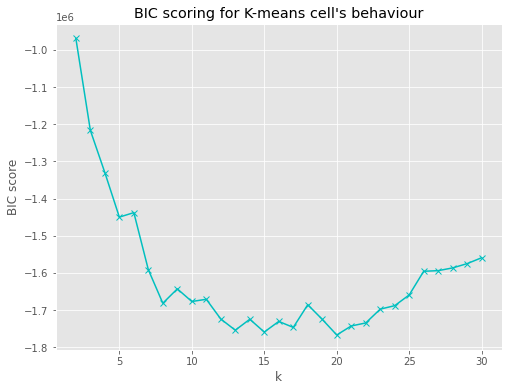

In [21]:
#identification du nombre de clusters possibles par critère de BIC
def plot_BIC(matrix,K):
    from sklearn import mixture
    BIC=[]
    for k in K:
        model=mixture.GaussianMixture(n_components=k,init_params='kmeans')
        model.fit(matrix)
        BIC.append(model.bic(matrix))
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(K,BIC,'-cx')
    plt.ylabel("BIC score")
    plt.xlabel("k")
    plt.title("BIC scoring for K-means cell's behaviour")
    return(BIC)

K = range(2,31)
BIC = plot_BIC(matrix,K)

In [22]:
cluster = KMeans(n_clusters=5,random_state=0)
clusters = pd.DataFrame()
clusters.index = matrix_T.index
clusters['cluster']=cluster.fit_predict(matrix_T)

In [23]:
clusters['cluster'].value_counts()

1    42
2    27
3    14
0     8
4     8
Name: cluster, dtype: int64

In [24]:
#Plotting cluster 1

cluster_1 = [i for i in (clusters.loc[clusters['cluster']== 0]).index]

pal = list(sns.color_palette(palette='magma', n_colors=len(cluster_1)).as_hex())
fig = go.Figure()
for d,p in zip(cluster_1, pal):
    fig.add_trace(go.Scatter(x = df_hourly.index,           
                             y = df_hourly[str(d)],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

print(fig.show())

None


In [25]:
#Plotting cluster 2
cluster_2 = [i for i in (clusters.loc[clusters['cluster']== 1]).index]

pal = list(sns.color_palette(palette='magma', n_colors=len(cluster_2)).as_hex())

fig = go.Figure()
for d,p in zip(cluster_2, pal):
    fig.add_trace(go.Scatter(x = df_hourly.index,        
                             y = df_hourly[str(d)],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

print(fig.show())

Output hidden; open in https://colab.research.google.com to view.

In [26]:
#Plotting cluster 3
cluster_3 = [i for i in (clusters.loc[clusters['cluster']== 2]).index]

pal = list(sns.color_palette(palette='magma', n_colors=len(cluster_3)).as_hex())

fig = go.Figure()
for d,p in zip(cluster_3, pal):
    fig.add_trace(go.Scatter(x = df_hourly.index,         
                             y = df_hourly[str(d)],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

print(fig.show())

Output hidden; open in https://colab.research.google.com to view.

### **Conclusion 2**
> - A 3 groups clustering has clearly seprated the time series according to their **Apparent trend with some mistakenly classified ones** 

In [27]:
df_hourly = df_hourly.T.drop_duplicates().T

##**Identifying the trend of the time series**

In [28]:
#trend_hourly = df_hourly.interpolate()
#trend_hourly.fillna(method='bfill', inplace=True)

trend_hourly = df_hourly.copy()
trend_hourly.fillna(method='bfill', inplace=True)

detrended_hourly = trend_hourly.copy()

components_decompose = ['trend', 'seasonality']
trend_serie = {col:dict.fromkeys(components_decompose) for col in trend_hourly.columns.tolist()}

for col in trend_hourly.columns:
    deseasonalized = trend_hourly[col] - seasonal_decompose(trend_hourly[col]).seasonal
    trend_result = pmk.hamed_rao_modification_test(deseasonalized, alpha=0.05)
    print(col, ':', trend_result.trend)
    trend_serie[col]['trend'] = {}
    trend_serie[col]['trend']['trend'] = trend_result.trend
    trend_serie[col]['trend']['p value'] = trend_result.p
    
    detrended_hourly[col] = detrended_hourly[col] - seasonal_decompose(detrended_hourly[col]).trend
    

2226 : decreasing
2429 : decreasing
161 : no trend
773 : no trend
406 : decreasing
675 : no trend
2562 : no trend
2643 : decreasing
2360 : no trend
994 : decreasing
1367 : decreasing


/usr/local/lib/python3.7/dist-packages/pymannkendall/pymannkendall.py:60: RuntimeWarning:

invalid value encountered in true_divide



225 : no trend
943 : no trend
1614 : decreasing
1312 : decreasing
1968 : decreasing
2091 : no trend
1067 : no trend
1795 : decreasing
1396 : decreasing
2199 : no trend
544 : increasing
1681 : decreasing
1418 : decreasing
397 : decreasing
471 : decreasing
392 : no trend
1599 : decreasing
487 : no trend
284 : no trend
1746 : decreasing
2034 : no trend
279 : no trend
2305 : decreasing
1722 : decreasing
643 : increasing
850 : increasing
727 : no trend
219 : no trend
1676 : no trend
851 : increasing
1065 : decreasing
452 : increasing
630 : no trend
2919 : increasing
1687 : decreasing
242 : no trend
2180 : increasing
23 : decreasing
1650 : no trend
62 : no trend
2608 : no trend
188 : no trend
415 : decreasing
1653 : no trend
1203 : no trend
2368 : decreasing
1323 : no trend
2782 : no trend
2276 : no trend
6 : no trend
2764 : decreasing
2373 : decreasing
1809 : no trend
1876 : increasing
2889 : decreasing
1924 : increasing
38 : no trend
987 : no trend
1557 : no trend
2381 : decreasing
1602 : 

In [29]:
pal = {'increasing':'#a12424', 'decreasing':'#ffdb00', 'no trend':'#ee7b06'}

In [30]:
fig = go.Figure()
#print(df_hourly)

for d in df_hourly.columns:
    fig.add_trace(go.Scatter(x = df_hourly.index,
                          y = df_hourly[d],
                          name = d,
                          line_color = pal[trend_serie[d]['trend']['trend']], 
                          fill=None))   #tozeroy 

print(fig.show())

Output hidden; open in https://colab.research.google.com to view.

In [31]:
increasing_series = [s for s in trend_serie.keys() if trend_serie[s]['trend']['trend']=='increasing']
#print(increasing_series)
decreasing_series = [s for s in trend_serie.keys() if trend_serie[s]['trend']['trend']=='decreasing']
#print(decreasing_series)
no_trend_series = [s for s in trend_serie.keys() if trend_serie[s]['trend']['trend']=='no trend']
#print(no_trend_series)

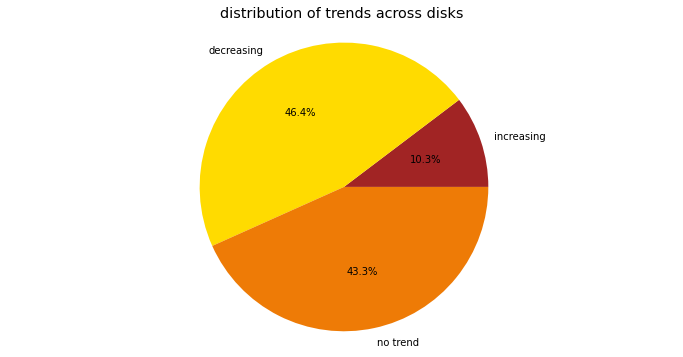

In [32]:
fig1, ax1 = plt.subplots()
ax1.pie([len(increasing_series), len(decreasing_series), len(no_trend_series)], labels=['increasing', 'decreasing', 'no trend'], 
        colors=['#a12424', '#ffdb00', '#ee7b06'], autopct='%1.1f%%')
ax1.axis('equal')  
plt.title("distribution of trends across disks")
plt.show()

In [33]:
#Implementing analysis util functions

#Constructs a Kats ts from a given df
def construct_ts(serie_id):
  df_temp = pd.DataFrame(columns={"time", "value"})
  df_temp['time'] = df_hourly[serie_id].index
  df_temp['value'] = list(df_hourly[serie_id])
  df_temp

  ts = TimeSeriesData(df_temp)
  id = serie_id
  return ts, id

#Returns additive decomposition  
#Additive is chosen because if seasonality is present it seems to be regular over time

def decompose_ts(ts,serie_id, save_path, plot = False):
  decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
  results = decomposer.decomposer()
  
  if bool :
    fig = decomposer.plot()

  if save_path !="":
    fig.save_fig(save_path,"\\",serie_id,'.png')
  
  return results

#Returns th fast Fourier transform result
def fft_result(ts, plot = False):
  fft_detector = FFTDetector(ts)
  #print(fft_detector.detector())

  if plot:
    fig2 = fft_detector.plot(24)

  return fft_result, fig2

#CumSum is used to detect changepoints
def cumsum_detect(ts, plot = False, fft=False):
  cumsum_detector = CUSUMDetector(ts)
  changepoints = cumsum_detector.detector()

  # Plot
  if plot:
    cumsum_detector.plot(changepoints)

  '''
  df = pd.DataFrame(changepoints, columns=['start_time', 'end_time',
                                           'confidence', 'direction', 'cp_index', 'mu0', 'mu1','delta', 'llr_int', 'llr'
                                           , 'regression_detected', 'stable_changepoint', 'p_value', 'p_value_int'])
  
  df_trunc = df['start_time', 'end_time']
  '''
  dic_changepoints = dict(changepoints)
  
  if(len(dic_changepoints) == 0):
    return NULL

  return dic_changepoints.keys()


#Bocpd is used to further confirm or infirm the previous calculated changepoints

def bocpd_detect(ts, plot = False, ci = .95):
  bocpd_detector = BOCPDetector(ts)

  changepoints = bocpd_detector.detector(model=BOCPDModelType.NORMAL_KNOWN_MODEL, changepoint_prior=0.01, threshold=ci)
  
  '''
  for changepoint in changepoints:
      print(changepoint[0])
  '''
      
  # Plot
  if plot:
    bocpd_detector.plot(changepoints)

  return changepoints

#Returns detected outliers that significantly differ from the rest of the data 
def outlier_detection(ts, plot = False):
  outlier_detector = OutlierDetector(ts, "additive")

  outlier_detector.detector()
  outliers = outlier_detector.outliers


  ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)

  if plot:
    ax = ts.to_dataframe().plot(x="time", y="value")
    ts_day_outliers_interpolated.to_dataframe().plot(x="time", y="y_0", ax=ax)
    plt.legend(labels=["original ts", "ts with removed outliers"])
    plt.show()
  return outliers

#Approximates the seasonalities that may exist in the time series  

def seasonality_acf_detect(ts, alpha_value = 0.01):
  detector = ACFDetector(ts)

  # run detector

  seasonality_test = detector.detector(diff=1, alpha = alpha_value)

  #print(seasonality_test)

  # seasonality decomposition, returns trend, seasonal, residual term
  #detector.remover()
  # plot acf and decompsition results
  #detector.plot()

  return seasonality_test

In [34]:

def seasonality_test(series):
        seasoanl = False
        idx = np.arange(len(series.index)) % 124
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal

for col in df_hourly.columns:
  print(seasonality_test(df_hourly[col]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [35]:
!pip install kats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from kats.detectors.cusum_detection import CUSUMMetadata

statistical_tests_hourly = pd.DataFrame(columns=['serie_id', 'trend', 'is_seasonal', 'changepoints_1', 'changepoints_2', 'outliers'])
statistical_tests_hourly['serie_id'] = df_hourly.columns

statistical_tests_hourly['changepoints_1'] = statistical_tests_hourly['changepoints_1'].astype(object) 
statistical_tests_hourly['changepoints_2'] = statistical_tests_hourly['changepoints_1'].astype(object) 
statistical_tests_hourly['outliers'] = statistical_tests_hourly['outliers'].astype(object) 


for col, i in zip(df_hourly.columns, range(len(df_hourly.columns))):
  ts,id = construct_ts(col)
  
  statistical_tests_hourly.loc[i]['trend'] = trend_serie[col]['trend']['trend']
  
  seasonality_result = seasonality_acf_detect(ts)
  statistical_tests_hourly.loc[i]['is_seasonal'] = seasonality_result['seasonality_presence']

  changepoints1 = cumsum_detect(ts)
  #print(list(cumsum_detect(ts))[0].start_time)

  if(changepoints1 != NULL):
    #print(list(cumsum_detect(ts))[0].start_time)
    statistical_tests_hourly.loc[i]['changepoints_1'] = changepoints1
    #statistical_tests_hourly['changepoints_1_end'] = list(cumsum_detect(ts))[0].end_time

  outliers = outlier_detection(ts)
  if(len(outliers) != 0):
    statistical_tests_hourly.loc[i]['outliers'] = outliers


'''
  changepoints2 = bocpd_detect(ts)

  if(len(changepoints2) != 0):
    statistical_tests_hourly.loc[i]['changepoints_2'] = changepoints2
'''
  

  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarni

"\n  changepoints2 = bocpd_detect(ts)\n\n  if(len(changepoints2) != 0):\n    statistical_tests_hourly.loc[i]['changepoints_2'] = changepoints2\n"

In [37]:
changepoints2 = bocpd_detect(ts)

if(len(changepoints2) != 0):
  statistical_tests_hourly.loc[i]['changepoints_2'] = changepoints2

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



In [38]:
statistical_tests_hourly

,serie_id,trend,is_seasonal,changepoints_1,changepoints_2,outliers
0,2226,decreasing,False,(TimeSeriesChangePoint(start_time: 2021-05-27 ...,NaN,"[[2021-01-07 10:00:00, 2021-01-07 12:00:00, 20..."
1,2429,decreasing,True,(TimeSeriesChangePoint(start_time: 2021-06-11 ...,NaN,"[[2021-06-08 14:00:00, 2021-06-08 16:00:00, 20..."
2,161,no trend,True,NaN,NaN,[[]]
3,773,no trend,True,(TimeSeriesChangePoint(start_time: 2021-03-16 ...,NaN,"[[2021-04-22 18:00:00, 2021-04-22 20:00:00, 20..."
4,406,decreasing,True,(TimeSeriesChangePoint(start_time: 2021-07-07 ...,NaN,"[[2021-01-21 20:00:00, 2021-01-21 22:00:00, 20..."
...,...,...,...,...,...,...
92,1584,no trend,False,NaN,NaN,"[[2021-01-05 12:00:00, 2021-01-05 14:00:00, 20..."
93,2573,no trend,True,NaN,NaN,"[[2021-01-25 22:00:00, 2021-02-08 22:00:00, 20..."
94,1457,decreasing,True,(TimeSeriesChangePoint(start_time: 2021-07-05 ...,NaN,"[[2021-01-05 12:00:00, 2021-01-18 12:00:00, 20..."
95,2812,no trend,True,NaN,NaN,[[]]


In [39]:
statistical_tests_hourly.describe()

,serie_id,trend,is_seasonal,changepoints_1,changepoints_2,outliers
count,97,97,97,76,0,97
unique,97,3,2,76,0,84
top,2226,decreasing,True,(TimeSeriesChangePoint(start_time: 2021-05-27 ...,NaN,[[]]
freq,1,45,77,1,NaN,12


Full statistical study on serie N° :  57
>>>>>>>>>>>>>>>>>>>> Original plot [hourly]
>>>>>>>>>>>>>>>>>>>> Original plot [daily]
>>>>>>>>>>>>>>>>>>> Decomposition result of the time serie :
>>>>>>>>>>>>>>>>>>> Apparent trend of the serie is :  decreasing
>>>>>>>>>>>>>>>>>>> FFT plot of this timeserie


>>>>>>>>>>>>>>>>>> Detected seasonalities for the timeserie
{'seasonality_presence': True, 'seasonalities': [1355, 1356]}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



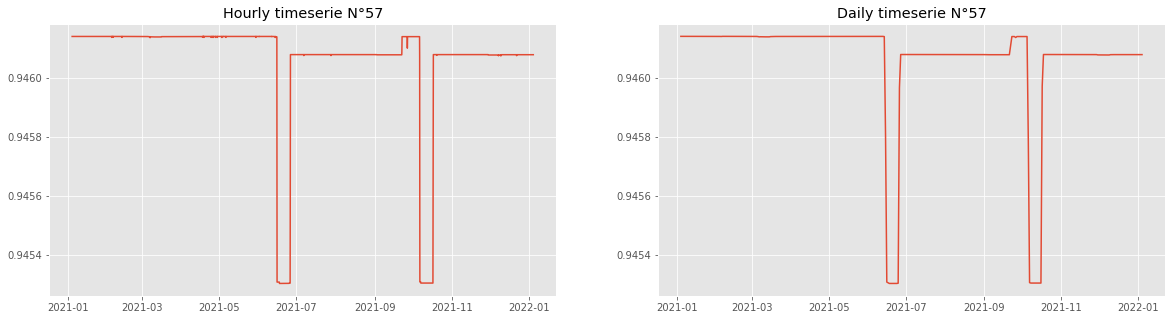

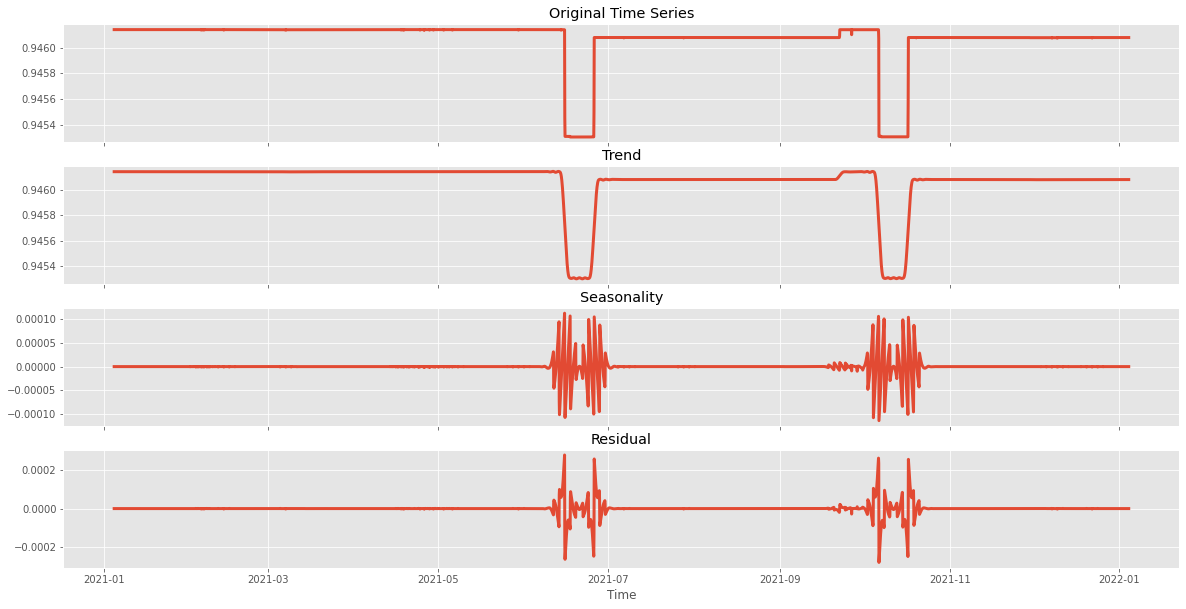

In [61]:


def trend_seasonality_analysis(serie_id):
  print("Full statistical study on serie N° : ", serie_id)
  fig,ax = plt.subplots(1,2, figsize=(20,5))

  print(">>>>>>>>>>>>>>>>>>>> Original plot [hourly]")
  ax[0].plot(df_hourly[serie_id])
  ax[0].title.set_text("Hourly timeserie N°"+serie_id)

  print('>>>>>>>>>>>>>>>>>>>> Original plot [daily]')
  ax[1].plot(df_daily[serie_id])
  ax[1].title.set_text("Daily timeserie N°"+serie_id)

  ts, id = construct_ts(serie_id)

  print('>>>>>>>>>>>>>>>>>>> Decomposition result of the time serie :')
  decompose_ts(ts, serie_id, save_path='' ,plot=True)
  
  print('>>>>>>>>>>>>>>>>>>> Apparent trend of the serie is : ', trend_serie[serie_id]['trend']['trend'])

  print('>>>>>>>>>>>>>>>>>>> FFT plot of this timeserie')
  results, fig2 = fft_result(ts, plot=True)
  display(fig2)

  print('>>>>>>>>>>>>>>>>>> Detected seasonalities for the timeserie')
  print(seasonality_acf_detect(ts))



trend_seasonality_analysis('57')

Detected changepoints using two different tests  57
>>>>>>>>>>>>>>>>>>> Changepoints detected using CumSum test


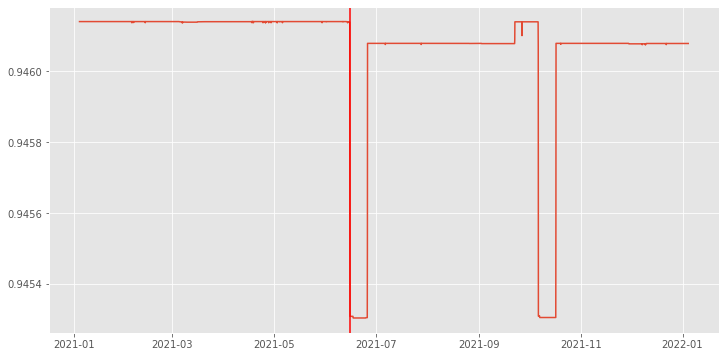

>>>>>>>>>>>>>>>>>>> Changepoints detected using bocpd test


/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/usr/local/lib/python3.7/dist-packages/ax/core/parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



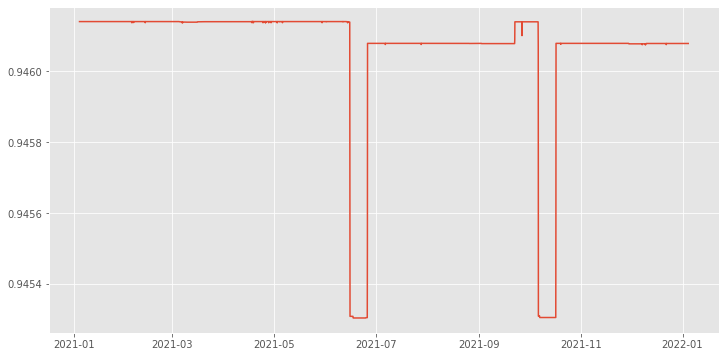

>>>>>>>>>>>>>>>>>>> Outliers detected for the serie


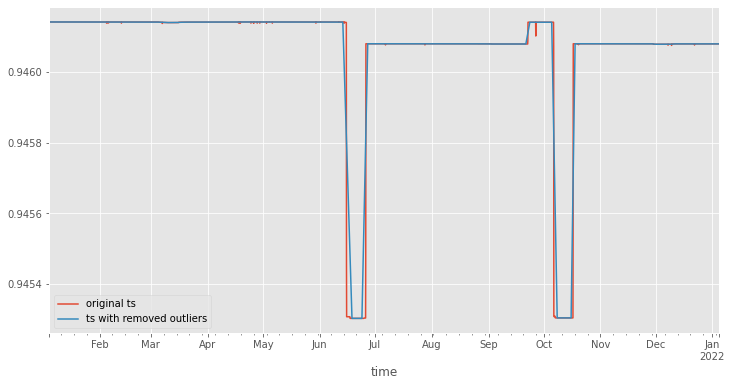

In [62]:
def changepoints_outliers_analysis(serie_id):
  print("Detected changepoints using two different tests ", serie_id)
  ts, id = construct_ts(serie_id)
  print('>>>>>>>>>>>>>>>>>>> Changepoints detected using CumSum test')
  cumsum_detect(ts, plot=True)

  print('>>>>>>>>>>>>>>>>>>> Changepoints detected using bocpd test')
  bocpd_detect(ts, plot=True)

  print('>>>>>>>>>>>>>>>>>>> Outliers detected for the serie')
  outlier_detection(ts, plot=True)


changepoints_outliers_analysis('57')